# 1. Implementando uma rede simples (MLP) usando o Keras - **Breast Cancer Wisconsin (Diagnostic) Dataset (WDBC)**


O conjunto de dados utilizado foi o Breast Cancer Wisconsin (Diagnostic) que é amplamente utilizado em pesquisas de aprendizado de máquina para a tarefa de classificação binária. Ele contém informações obtidas a partir da análise digitalizada de imagens de biópsias de tumores de mama.

O objetivo é prever se um tumor é Maligno (M) ou Benigno (B) a partir de 30 variáveis numéricas, que descrevem características como textura, concavidade, simetria e outras medidas relacionadas às células.

O dataset possui 569 amostras no total, com uma distribuição de 212 malignos e 357 benignos, representando um problema real e desafiador de diagnóstico médico. Esse tipo de tarefa é importante para auxiliar na detecção precoce de câncer, reduzindo riscos e apoiando decisões clínicas.

## 1.1 Imports

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

## 1.2 Exploração do Dataset

### 1.2.1 Carregar Dataset

In [23]:
# Nomes conforme wdbc.names
col_names = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
df = pd.read_csv("wdbc.data", header=None, names=col_names)

# Opções de visualização
pd.set_option("display.max_columns", 40)
pd.set_option("display.width", 120)
pd.set_option("display.float_format", "{:,.4f}".format)

print("Dataset carregado!")


Dataset carregado!


### 1.2.2 Visão geral do dataset e distribuição das classes

Aqui é apresentado uma visão geral do conjunto de dados, destacando o número total de amostras e colunas, bem como a tarefa de classificação binária (diagnóstico de tumores malignos e benignos). Além disso, é exibido a distribuição das classes em tabela e gráfico de barras, o que nos ajuda a verificar o balanceamento entre as categorias.

,Contagem,Proporção
Classe,,
B,357,62.7%
M,212,37.3%


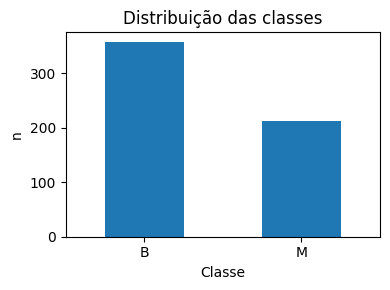

In [24]:
# Visão geral e classes
total_rows, total_cols = df.shape

display(HTML(f"""
<h3 style="margin-bottom:0">Breast Cancer Wisconsin (Diagnostic)</h3>
<p style="margin-top:6px">Amostras: <b>{total_rows}</b> • Colunas: <b>{total_cols}</b>
(1 ID, 1 alvo, 30 features numéricas) • Tarefa: <b>classificação binária</b> (M vs B)</p>
"""))

# Distribuição
dist = df["Diagnosis"].value_counts().rename_axis("Classe").to_frame("Contagem")
dist["Proporção"] = (dist["Contagem"] / len(df)).map("{:.1%}".format)

display(
    dist.style
        .bar(subset=["Contagem"], align="mid", vmax=dist["Contagem"].max(), color="#ddd")
        .set_caption("Distribuição das classes")
)

# Gráfico
plt.figure(figsize=(4,3))
dist["Contagem"].plot(kind="bar")
plt.title("Distribuição das classes")
plt.ylabel("n")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### 1.2.3 Estatísticas descritivas das features

Nesta etapa é calculado estatísticas descritivas (média, desvio padrão, valores mínimos e máximos, entre outros) para cada uma das 30 variáveis numéricas do dataset. Esse resumo nos permite entender a escala dos atributos e identificar possíveis variações importantes entre eles.

In [25]:
# Estatísticas descritivas
desc = df.iloc[:, 2:].describe().T  # só as 30 features
display(
    desc.style
        .background_gradient(subset=["mean"], cmap="Greens")
        .background_gradient(subset=["std"], cmap="Oranges")
        .set_caption("Estatísticas descritivas por feature (mean/std destacados)")
)


,count,mean,std,min,25%,50%,75%,max
feature_1,569.000000,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.110000
feature_2,569.000000,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.280000
feature_3,569.000000,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.500000
feature_4,569.000000,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.000000
feature_5,569.000000,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.163400
feature_6,569.000000,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.345400
feature_7,569.000000,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.426800
feature_8,569.000000,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.201200
feature_9,569.000000,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.304000
feature_10,569.000000,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.097440


### 1.2.4 Correlação das features com a variável alvo

Aqui é analisado a correlação de cada feature com a variável alvo (diagnóstico: maligno ou benigno). Foi listado as 10 variáveis mais relevantes e as apresentamos em gráfico de barras, o que nos auxilia a identificar quais atributos têm maior poder discriminativo para a tarefa de classificação.

,abs(corr)
feature_27,0.659610
feature_7,0.696360
feature_4,0.708984
feature_1,0.730029
feature_24,0.733825
feature_3,0.742636
feature_21,0.776454
feature_8,0.776614
feature_23,0.782914
feature_28,0.793566


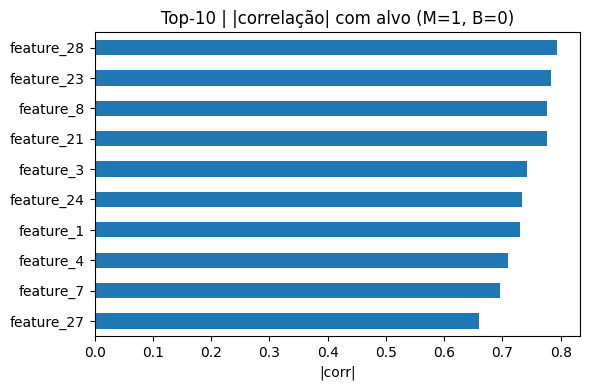

In [26]:
  # Correlações com o alvo
# Converte alvo para binário (M=1, B=0)
y = (df["Diagnosis"] == "M").astype(int)
X = df.iloc[:, 2:]

# Correlação (Pearson point-biserial ~ Pearson com alvo binário)
corr_with_y = X.apply(lambda c: np.corrcoef(c, y)[0,1])
top10 = corr_with_y.abs().sort_values(ascending=False).head(10).sort_values()

display(
    top10.to_frame("abs(corr)").style.set_caption("Top-10 features mais correlacionadas com o alvo")
)

plt.figure(figsize=(6,4))
top10.plot(kind="barh")
plt.title("Top-10 | |correlação| com alvo (M=1, B=0)")
plt.xlabel("|corr|")
plt.tight_layout()
plt.show()


### 1.2.5 Exemplos de amostras

Agora, é exibido algumas linhas do dataset com as colunas de identificação, diagnóstico e as primeiras cinco features numéricas. Essa visualização serve como amostra prática da estrutura dos dados que serão utilizados no treinamento do modelo.

In [27]:
# Amostras
subset_cols = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 6)]
display(
    df[subset_cols].head(8)
        .style.set_caption("Exemplos de amostras (ID, alvo e 5 primeiras features)")
)


,ID,Diagnosis,feature_1,feature_2,feature_3,feature_4,feature_5
0,842302,M,17.990000,10.380000,122.800000,1001.000000,0.118400
1,842517,M,20.570000,17.770000,132.900000,1326.000000,0.084740
2,84300903,M,19.690000,21.250000,130.000000,1203.000000,0.109600
3,84348301,M,11.420000,20.380000,77.580000,386.100000,0.142500
4,84358402,M,20.290000,14.340000,135.100000,1297.000000,0.100300
5,843786,M,12.450000,15.700000,82.570000,477.100000,0.127800
6,844359,M,18.250000,19.980000,119.600000,1040.000000,0.094630
7,84458202,M,13.710000,20.830000,90.200000,577.900000,0.118900


## 1.3 Modelo Sequencial em Keras

### 1.3.1 Preparação dos dados

In [28]:
# Lê o WDBC
col_names = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
df = pd.read_csv("wdbc.data", header=None, names=col_names)

# Alvo binário: M=1 (maligno), B=0 (benigno)
y = (df["Diagnosis"] == "M").astype(int).values

# Features (remove ID e Diagnosis)
X = df.drop(columns=["ID", "Diagnosis"]).values

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train.shape, X_test.shape


((455, 30), (114, 30))

### 1.3.2 Modelo sequencial com 1 Dense + sigmoid e métrica F1 custom

In [31]:
@tf.function
def f1_metric(y_true, y_pred):
    # Garantir formas e tipos compatíveis
    y_true = tf.cast(K.flatten(y_true), tf.float32)
    y_pred = tf.cast(K.flatten(y_pred), tf.float32)

    # Binariza previsões (threshold 0.5)
    y_pred_bin = tf.cast(y_pred >= 0.5, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred_bin)
    fp = tf.reduce_sum((1.0 - y_true) * y_pred_bin)
    fn = tf.reduce_sum(y_true * (1.0 - y_pred_bin))

    precision = tp / (tp + fp + K.epsilon())
    recall    = tp / (tp + fn + K.epsilon())
    f1 = 2.0 * precision * recall / (precision + recall + K.epsilon())
    return f1

# Modelo: uma única camada densa com 1 unidade (sigmoid)
model = Sequential([
    Dense(1, activation="sigmoid", input_shape=(X_train.shape[1],))
])

# Compilação conforme pedido
model.compile(
    optimizer=Adam(),                    # otimizador
    loss="binary_crossentropy",          # função de perda
    metrics=["accuracy", f1_metric]      # métricas: acurácia e F1
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

## 1.4 Treinar agora 50 épocas, batch_size=10

In [32]:
model.compile(
    optimizer=Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy", f1_metric]
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=10,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7713 - f1_metric: 0.6845 - loss: 0.5560 - val_accuracy: 0.8242 - val_f1_metric: 0.7457 - val_loss: 0.4783
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8833 - f1_metric: 0.8179 - loss: 0.4153 - val_accuracy: 0.8462 - val_f1_metric: 0.7631 - val_loss: 0.4113
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8870 - f1_metric: 0.8444 - loss: 0.3730 - val_accuracy: 0.8791 - val_f1_metric: 0.8398 - val_loss: 0.3655
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9115 - f1_metric: 0.8059 - loss: 0.3139 - val_accuracy: 0.9121 - val_f1_metric: 0.8973 - val_loss: 0.3300
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8949 - f1_metric: 0.8585 - loss: 0.3324 - val_accuracy: 0.9231 - val_f1_metric: 0.9082 - val_loss: 0.3028
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9227 - f1_metric: 0.8719 - loss: 0.2933 - val_accuracy: 0.9231 - val_f1_metric: 0.908

## 1.5 Avaliação no conjunto de teste

In [33]:
# Previsões no conjunto de teste
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Acurácia e F1 com scikit-learn
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print(f"Acurácia no teste: {acc:.4f}")
print(f"F1-score no teste: {f1:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Acurácia no teste: 0.9825
F1-score no teste: 0.9756


## 1.6 Interpretação dos Resultados

- O modelo atingiu altíssima acurácia e F1-score. Isso significa que ele classificou corretamente cerca de 98% das amostras de teste.

- O F1-score elevado indica que tanto a precisão (evitar falsos positivos) quanto o recall (evitar falsos negativos) estão bem balanceados — o que é essencial em problemas médicos, já que perder um caso maligno seria crítico.

- Esses números mostram que mesmo uma arquitetura extremamente simples (basicamente uma regressão logística com Keras) já é muito eficaz para esse dataset.